# 📊 Análise Exploratória do Censo e Produção Científica

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import sqlite3
import scipy.stats as stats
import statsmodels.api as sm

pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")

In [49]:
import sys
import os

sys.path.append(os.path.abspath("../scripts"))

from limpeza import carregar_e_filtrar

base_path = '../data/'  

df_cursos, df_ies = carregar_e_filtrar(base_path)

print(df_cursos.head())
print(df_ies.head())


   NU_ANO_CENSO NO_REGIAO  CO_REGIAO NO_UF SG_UF  CO_UF NO_MUNICIPIO  \
0          2023       NaN        NaN   NaN   NaN    NaN          NaN   
1          2023       NaN        NaN   NaN   NaN    NaN          NaN   
2          2023       NaN        NaN   NaN   NaN    NaN          NaN   
3          2023       NaN        NaN   NaN   NaN    NaN          NaN   
4          2023       NaN        NaN   NaN   NaN    NaN          NaN   

   CO_MUNICIPIO  IN_CAPITAL  TP_DIMENSAO  TP_ORGANIZACAO_ACADEMICA  TP_REDE  \
0           NaN         NaN            2                         1        2   
1           NaN         NaN            2                         1        2   
2           NaN         NaN            2                         1        2   
3           NaN         NaN            2                         2        2   
4           NaN         NaN            3                         1        1   

   TP_CATEGORIA_ADMINISTRATIVA  IN_COMUNITARIA  IN_CONFESSIONAL  CO_IES  \
0                

## Cursos por UF

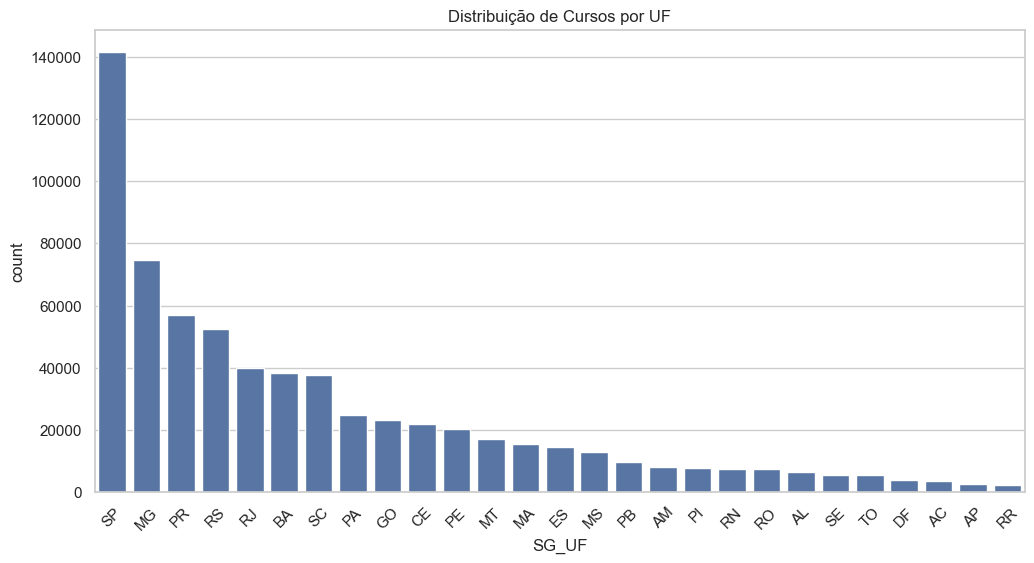

In [50]:
plt.figure(figsize=(12,6))
sns.countplot(data=df_cursos, x='SG_UF', order=df_cursos['SG_UF'].value_counts().index)
plt.title('Distribuição de Cursos por UF')
plt.xticks(rotation=45)
plt.show()

## Cursos por Categoria Administrativa

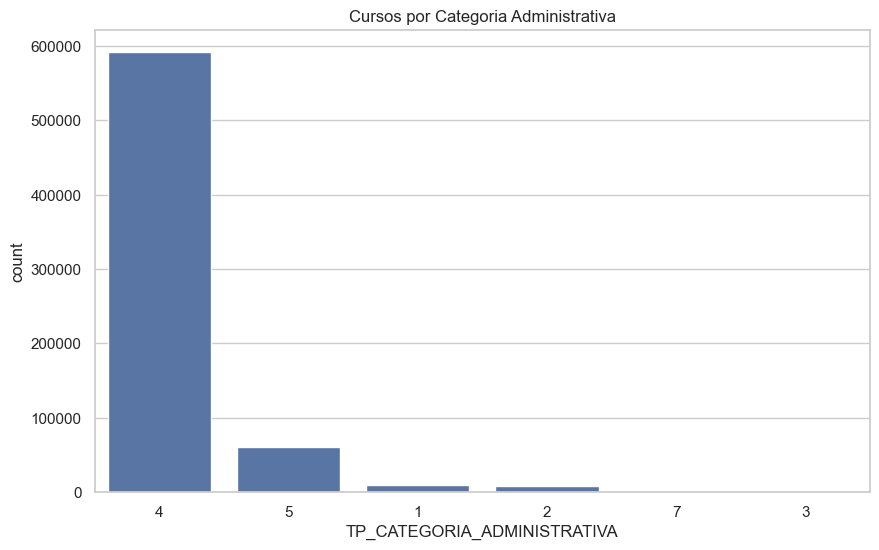

In [51]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df_cursos, x='TP_CATEGORIA_ADMINISTRATIVA', order=df_cursos['TP_CATEGORIA_ADMINISTRATIVA'].value_counts().index)
plt.title('Cursos por Categoria Administrativa')
plt.show()


## Cursos por Organização Acadêmica

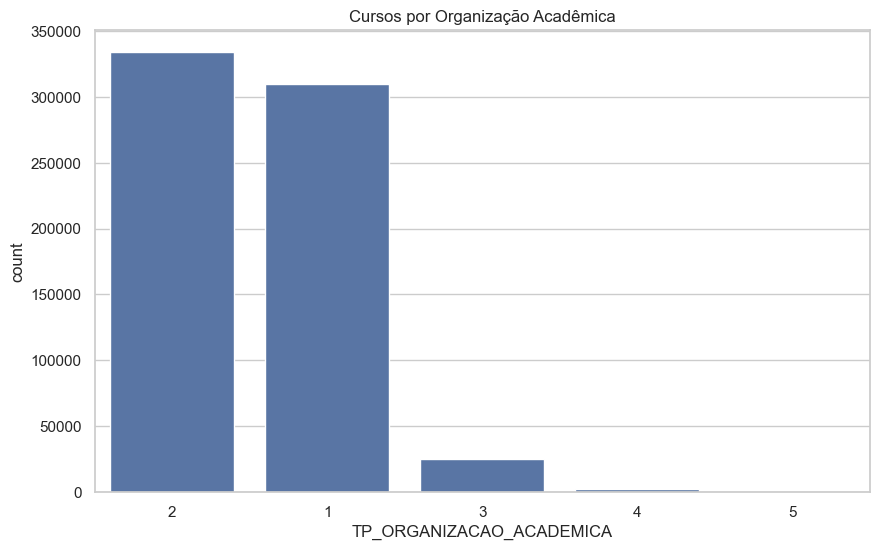

In [52]:
plt.figure(figsize=(10, 6))
sns.countplot(
    data=df_cursos,
    x='TP_ORGANIZACAO_ACADEMICA',
    order=df_cursos['TP_ORGANIZACAO_ACADEMICA'].value_counts().index
)
plt.title('Cursos por Organização Acadêmica')
plt.show()


## Heatmap: Cursos por UF vs Organização Acadêmica

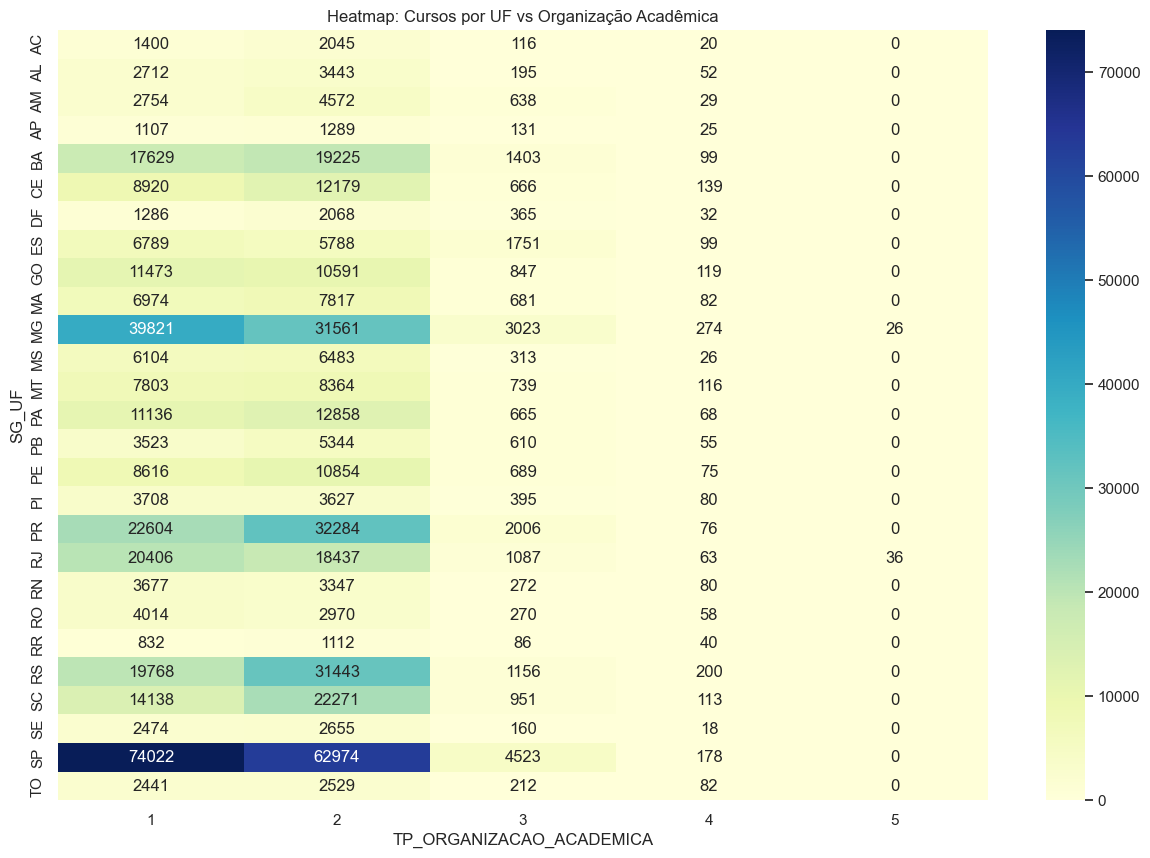

In [53]:
pivot = df_cursos.pivot_table(
    index='SG_UF',
    columns='TP_ORGANIZACAO_ACADEMICA',
    values='NO_CURSO',
    aggfunc='count',
    fill_value=0
)

plt.figure(figsize=(15, 10))
sns.heatmap(pivot, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Heatmap: Cursos por UF vs Organização Acadêmica')
plt.show()

## Consulta SQL Relacional

In [54]:


file_cnpq = '../data/Relatorio_de_dados_abertos_CNPq (1º SEM 2023)(snICJ).xlsx'
df_bolsistas = pd.read_excel(file_cnpq, skiprows=5)


df_cursos_uf = df_cursos.groupby('SG_UF').size().reset_index(name='qtd_cursos')


df_bolsistas_uf = df_bolsistas.groupby('Sigla UF Destino').size().reset_index(name='qtd_bolsistas')

df_sql = pd.merge(df_cursos_uf, df_bolsistas_uf, left_on='SG_UF', right_on='Sigla UF Destino', how='left')
df_sql['qtd_bolsistas'] = df_sql['qtd_bolsistas'].fillna(0).astype(int)
df_sql = df_sql.sort_values('qtd_cursos', ascending=False)

print(df_sql)



   SG_UF  qtd_cursos Sigla UF Destino  qtd_bolsistas
25    SP      141697               SP          21056
10    MG       74705               MG           9433
17    PR       56970               PR           5585
22    RS       52567               RS           8714
18    RJ       40029               RJ          24055
4     BA       38356               BA           3231
23    SC       37473               SC           3713
13    PA       24727               PA           2347
8     GO       23030               GO           1938
5     CE       21904               CE           2692
15    PE       20234               PE           4062
12    MT       17022               MT           1177
9     MA       15554               MA            748
7     ES       14427               ES           1157
11    MS       12926               MS           1212
14    PB        9532               PB           2579
2     AM        7993               AM           1080
16    PI        7810               PI         

## Visualização da Consulta SQL

In [55]:
fig = px.bar(df_sql.melt(id_vars='SG_UF', value_vars=['qtd_cursos', 'qtd_bolsistas']),
             x='SG_UF', y='value', color='variable',
             barmode='group',
             labels={'value': 'Quantidade', 'variable': 'Indicador'},
             text_auto=True,
             title='Comparação: Cursos vs Bolsistas por UF (via SQL)',
             width=1000, height=500)
fig.show()

## Análise Estatística: Correlação

In [56]:
corr, p_value = stats.pearsonr(df_sql['qtd_cursos'], df_sql['qtd_bolsistas'])
print(f'Correlação Pearson: {corr:.2f} (p-valor: {p_value:.4f})')

Correlação Pearson: 0.68 (p-valor: 0.0001)


## Regressão Linear

In [57]:
X = df_sql['qtd_cursos']
y = df_sql['qtd_bolsistas']

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          qtd_bolsistas   R-squared:                       0.467
Model:                            OLS   Adj. R-squared:                  0.446
Method:                 Least Squares   F-statistic:                     21.94
Date:                Sat, 21 Jun 2025   Prob (F-statistic):           8.46e-05
Time:                        23:22:17   Log-Likelihood:                -265.14
No. Observations:                  27   AIC:                             534.3
Df Residuals:                      25   BIC:                             536.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        785.0919   1157.899      0.678      0.5

## Conclusões e Recomendações

- Maior concentração de cursos em algumas UFs.
- Correlação positiva entre cursos e bolsistas CNPq.
- A regressão confirma relação direta.

**Recomendações:**

- Fomentar bolsas onde há menor densidade.
- Incentivar instituições privadas a investir mais em pesquisa.
- Melhorar a integração entre bases públicas.